In [0]:
!pip install tensorflow==2.0.0b1
!pip install SimpleITK
import tensorflow as tf
assert tf.__version__=='2.0.0-beta1'
# DON'T use the magic %tensorflow_version 2.0, it will load the stable version which could alter the model output.

from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython import display
import time
import math
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('./drive/My Drive/Segmentation')

print(tf.__version__)

from google.colab import drive
drive.mount('/content/drive')

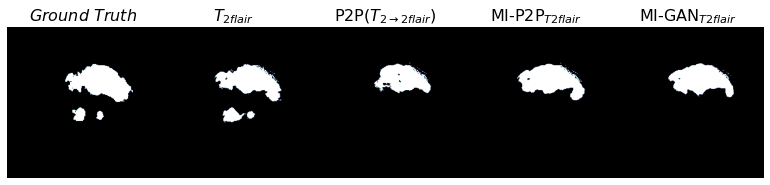

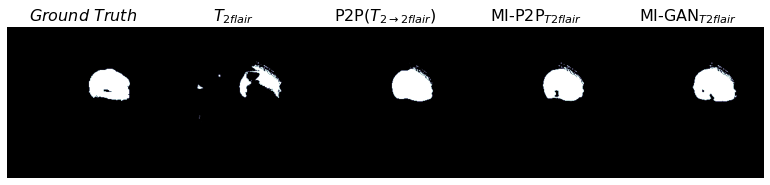

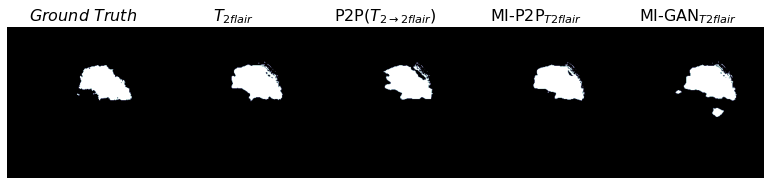

In [0]:
indexes = [6, 38, 76]     # selecting the most interesting samples from the dataset

for i in indexes:
    plot_images(gt[i], segmentation[i], segm_p2p_pred[i], segm_mip2p_pred[i], segm_migan_pred[i])

In [0]:
mods = ['MR_Flair_mri', 'pix2pix_Flair_mri', 'MIpix2pix_Flair_mri', 'MIGAN_Flair_mri', 'OT_mri']
BATCH_SIZE = 128


# PROCESSING IMAGES IN THE BATCH
def process_batch(batch):   # takes in input a raw_record[mod].numpy()
    batch = tf.io.decode_raw(batch, tf.float32)
    batch = tf.reshape(batch, (1, 256, 256))
    batch = tf.squeeze(batch)
    batch = tf.expand_dims(batch, axis=2)
    return batch

def retrieve_dataset(dataset_dir, shuffle=False, shuffle_buffer=128):
    dataset = tf.data.TFRecordDataset(dataset_dir)
    # Create a dictionary describing the features.
    image_feature_description = {
        mods[0]: tf.io.FixedLenFeature([], tf.string),
        mods[1]: tf.io.FixedLenFeature([], tf.string),
        mods[2]: tf.io.FixedLenFeature([], tf.string),
        mods[3]: tf.io.FixedLenFeature([], tf.string),
        mods[4]: tf.io.FixedLenFeature([], tf.string),
    }
    def _parse_image_function(example_proto):
    # Parse the input tf.Example proto using the dictionary above.
        parsed = tf.io.parse_single_example(example_proto, image_feature_description)
        batch0 = process_batch(parsed[mods[0]])
        batch1 = process_batch(parsed[mods[1]])
        batch2 = process_batch(parsed[mods[2]])
        batch3 = process_batch(parsed[mods[3]])
        batch4 = process_batch(parsed[mods[4]])
        return batch0, batch1, batch2, batch3, batch4

    dataset = dataset.shuffle(shuffle_buffer, seed=1234567890, reshuffle_each_iteration=True) if shuffle else dataset
    dataset = dataset.map(_parse_image_function)
    dataset = dataset.batch(BATCH_SIZE) if BATCH_SIZE > 0 else dataset
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

def plot_images(*args): 

    if len(args) == 5:
        display_list = [args[0], args[1], args[2], args[3], args[4]] 
        title = [r'$\it{Ground\ Truth}$', r'$T_{2flair}$', r'P2P$(T_{2 \rightarrow 2flair})$', r'MI-P2P$_{T2flair}$' , r'MI-GAN$_{T2flair}$']
        # r'pix2pix$(T_{2 \rightarrow 1})$'
        figsize = (14, 5)
    else:
        display_list = [args[0], args[1], args[2], args[3], args[4], args[5], args[6], args[7], args[8]]
        title = [r'${T_{2flair}}$', r'$\it{Pred\ p2p}$', r'$\it{Pred\ MI-p2p}$', r'$\it{Pred\ MI-GAN}$', r'$\it{Ground\ Truth}$', r'$\it{Segmentation}$', r'$\it{Segm.\ p2p}$', r'$\it{Segm.\ MI-p2p}$', r'$\it{Segm.\ MI-GAN}$'] 
        figsize = (23, 12)
    plt.figure(1 , figsize)
    n = 0
    for i in range(len(args)):
        n += 1
        plt.subplot(1, len(args), n).title.set_text(title[i])
        plt.subplot(1, len(args), n).title.set_size(16)
        plt.imshow(tf.squeeze(display_list[i]), cmap='bone')
        plt.axis('off')
    plt.subplots_adjust(left=0, bottom=None, right=0.75, top=None, wspace=0.0, hspace=None)
    plt.show()

def print_128_images(idx, image):
    plt.figure(idx , figsize = (18 , 34))
    i = 0
    n = 0
    for i in range(128):
        n += 1
        plt.subplot(16 , 8 , n)
        plt.imshow(tf.squeeze(image[i]), cmap='bone')
        plt.title(n-1+ 32*idx)
        plt.xticks([]) , plt.yticks([])
    plt.subplots_adjust(left=0, bottom=None, right=0.65, top=None, wspace=0.0, hspace=None)

In [0]:
from DeepMRI import DeepMRI
import SegAN_IO_arch as arch

model_name = 'Segan_IO_TF2_brats_on_FLAIR' # The name of the folder inside './models' containing the model to load
mri_channels = 1 # input channels (modalities)

gan = DeepMRI(batch_size=BATCH_SIZE, size=256, mri_channels=mri_channels, model_name=model_name)
gan.build_model(load_model='last', seed=1234567890, arch=arch)

No GPU found, model running on CPU
No GPU found, model running on CPU
Using architecture: SegAN_IO_arch
Latest Checkpoint is: ./drive/My Drive/Segmentation/models/Segan_IO_TF2_brats_on_FLAIR/best_dice_score_168-29
Loaded model from: last, next epoch: 169


In [0]:
generated_norm_dataset = retrieve_dataset('./drive/My Drive/Segmentation/generated_testing_norm_mri.tfrecords', shuffle=True, shuffle_buffer=3584)

In [0]:
for tflair, p2p_pred, mip2p_pred, migan_pred, gt in generated_norm_dataset.take(1):
    segmentation = gan.generator(tflair, training=False)
    segm_p2p_pred = gan.generator(p2p_pred, training=False)
    segm_mip2p_pred = gan.generator(mip2p_pred, training=False)
    segm_migan_pred = gan.generator(migan_pred, training=False)

# Qualitative results from the segmentations of the generated images 



## 1st case: Before the segmentation each slice has been normalized with respect to the max and min values in the whole volume.

6


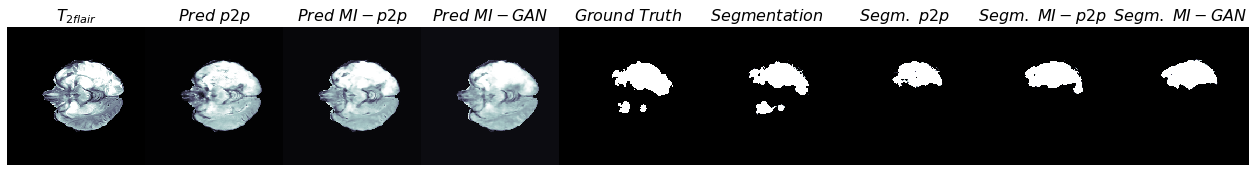

20


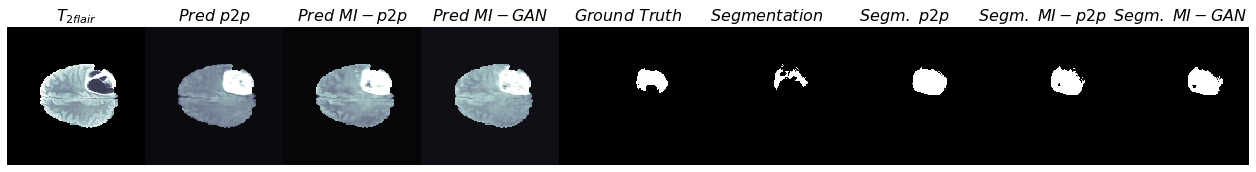

26


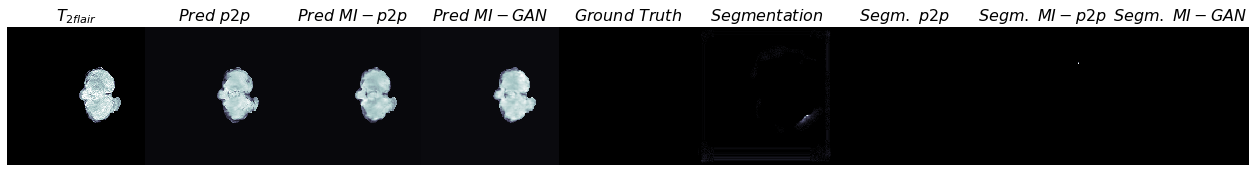

39


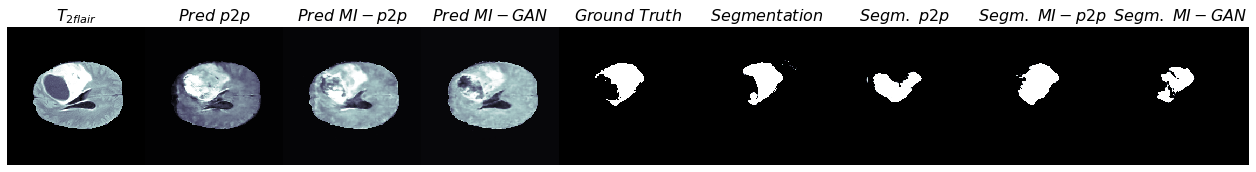

42


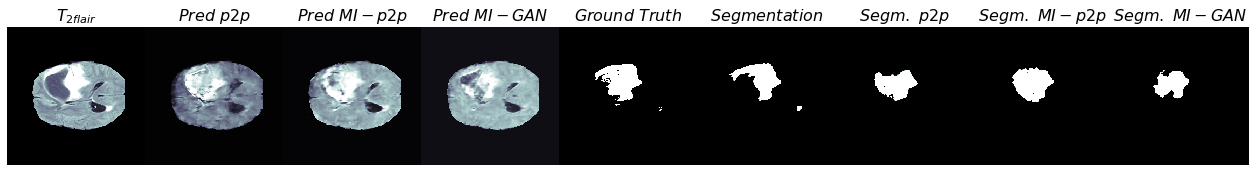

54


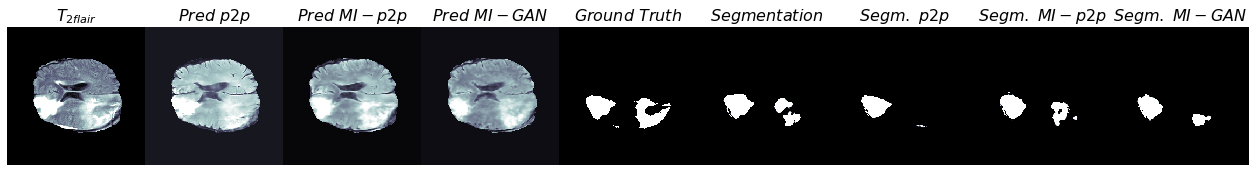

72


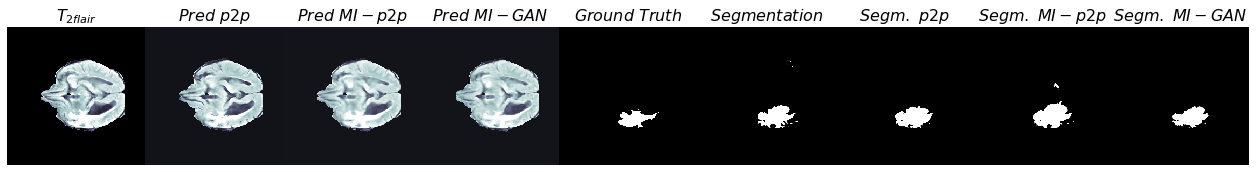

74


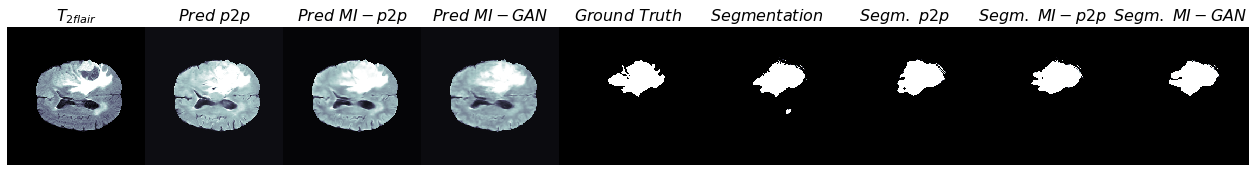

76


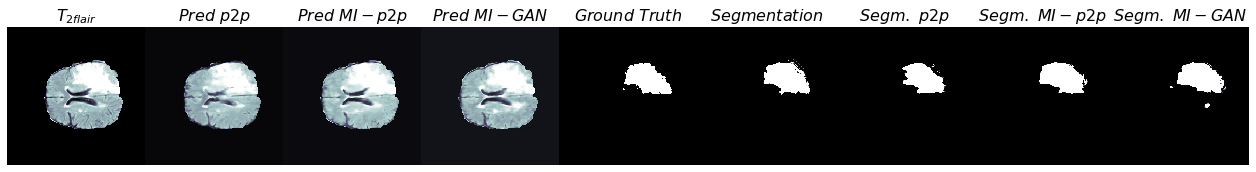

81


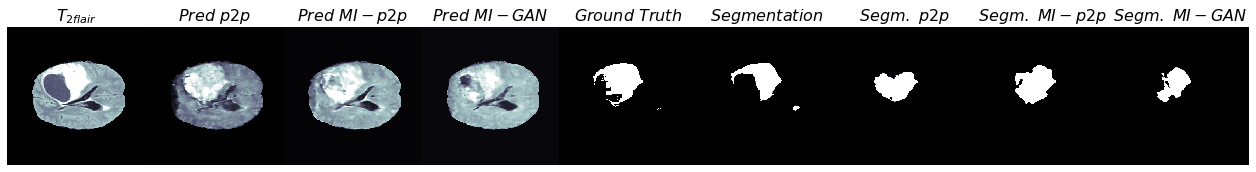

96


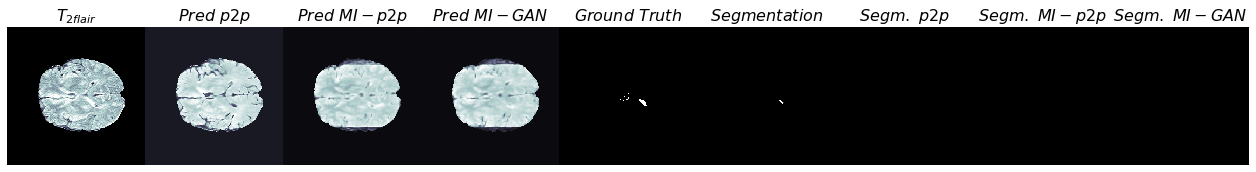

114


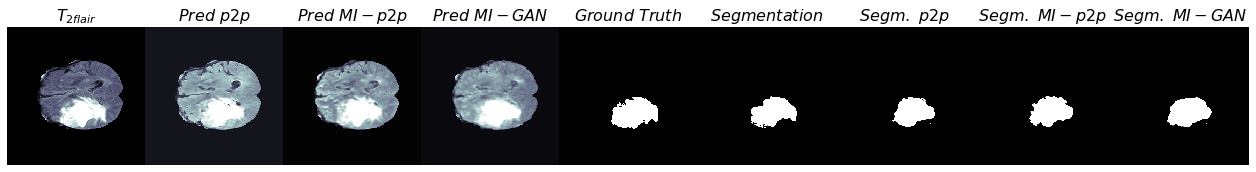

123


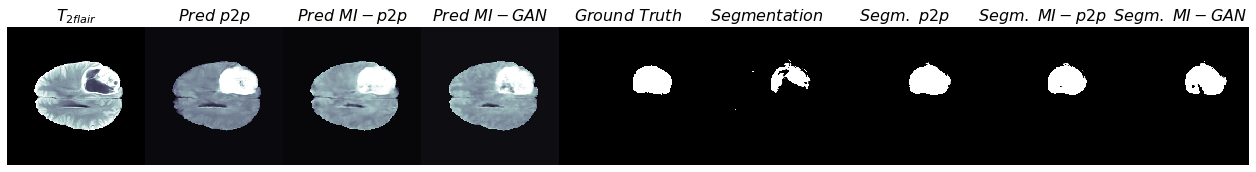

120


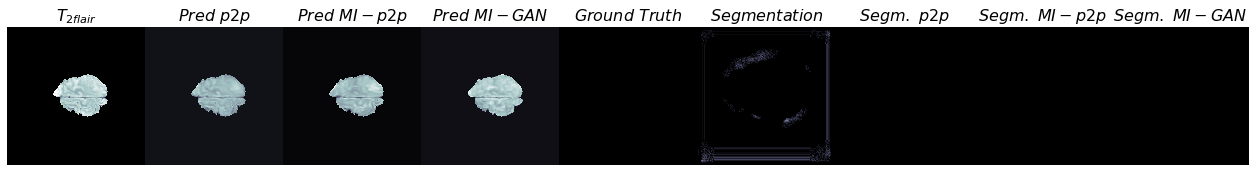

126


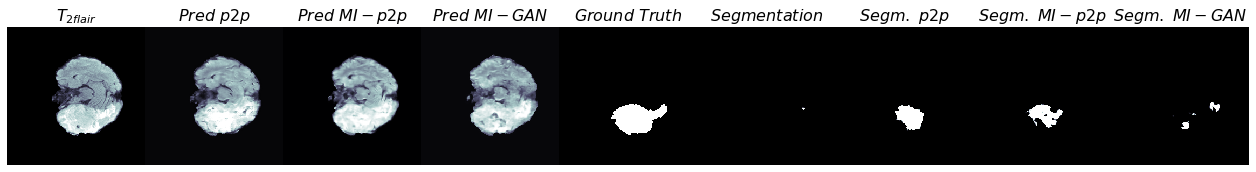

In [0]:
indexes = [6, 20, 26, 39, 42, 54, 72, 74, 76, 81, 96, 114, 123, 120, 126]     # selecting the most interesting samples from the dataset
for i in indexes:
    print(i)
    plot_images(tflair[i], p2p_pred[i], mip2p_pred[i], migan_pred[i], gt[i], segmentation[i], segm_p2p_pred[i], segm_mip2p_pred[i], segm_migan_pred[i])

## 2nd case: the generated images were NOT normalized at all.

In [0]:
generated_dataset = retrieve_dataset('./drive/My Drive/Segmentation/generated_testing_mri.tfrecords', shuffle=True, shuffle_buffer=3584)

In [0]:
for tflair, p2p_pred, mip2p_pred, migan_pred, gt in generated_dataset.take(1):
    segmentation = gan.generator(tflair, training=False)
    segm_p2p_pred = gan.generator(p2p_pred, training=False)
    segm_mip2p_pred = gan.generator(mip2p_pred, training=False)
    segm_migan_pred = gan.generator(migan_pred, training=False)

6


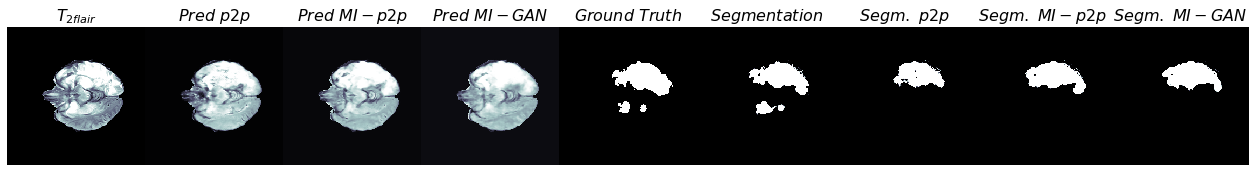

20


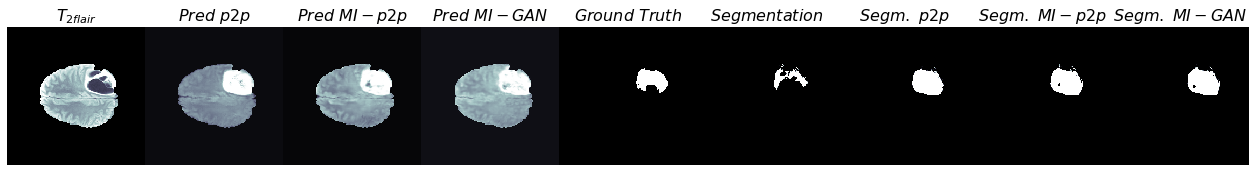

26


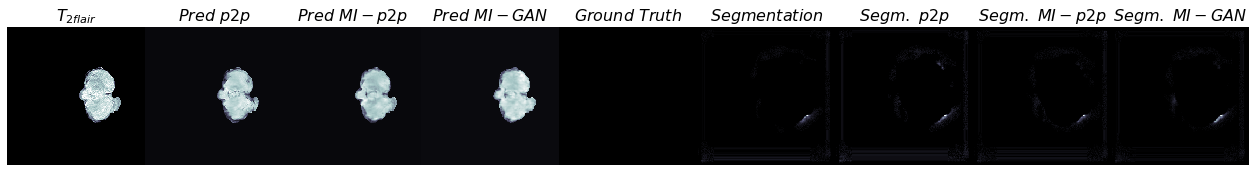

39


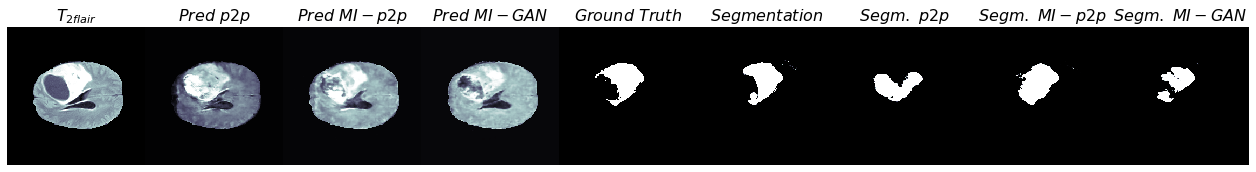

42


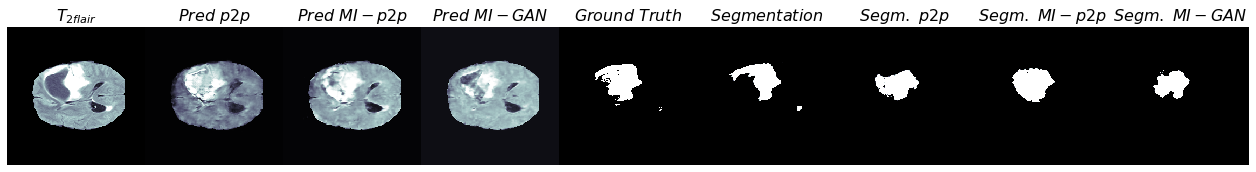

54


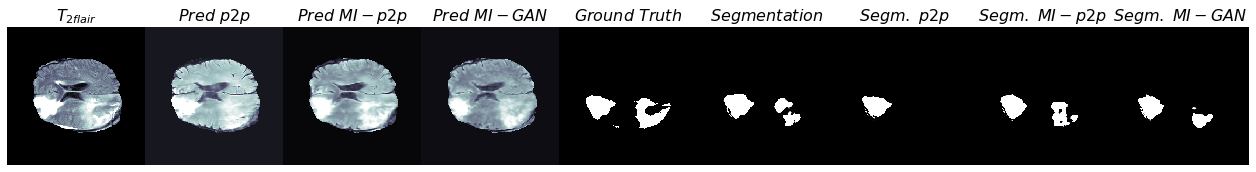

72


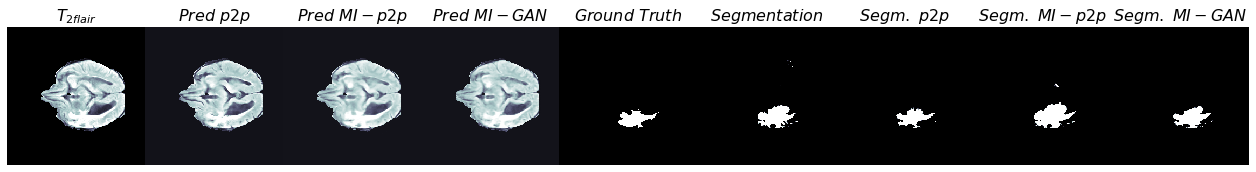

74


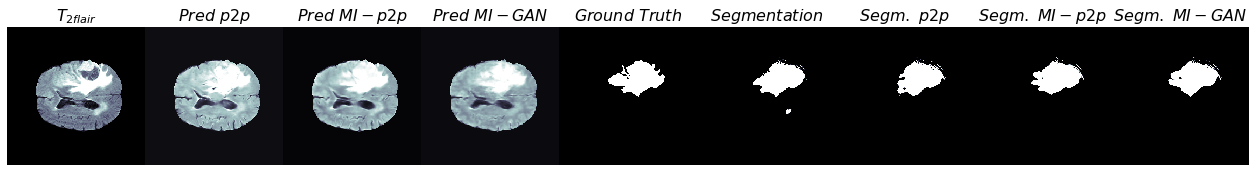

76


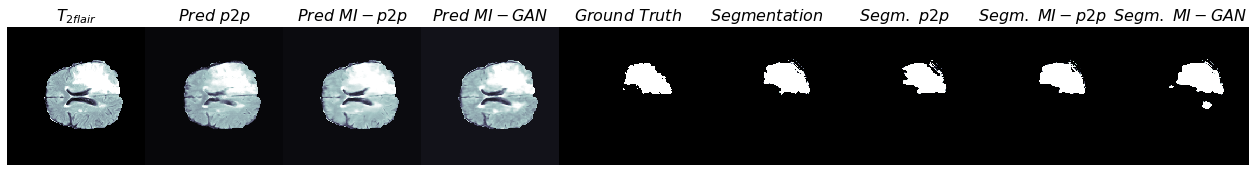

81


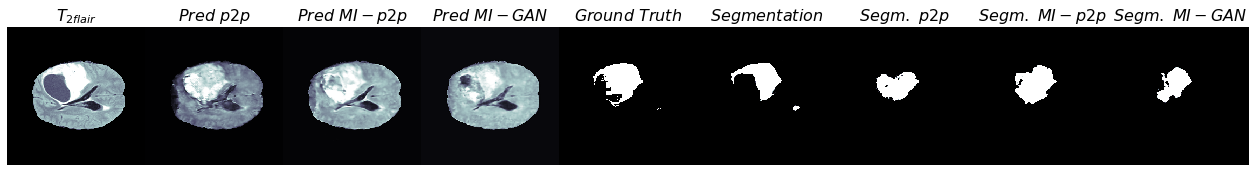

96


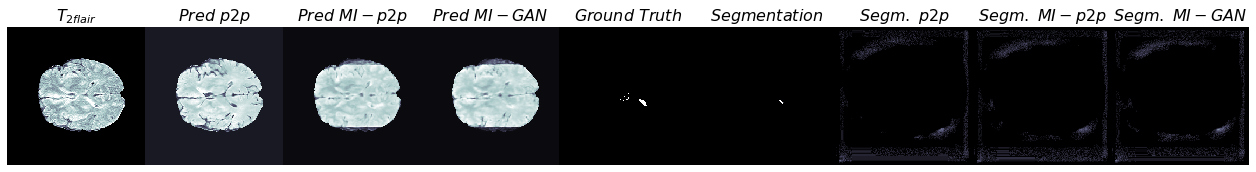

114


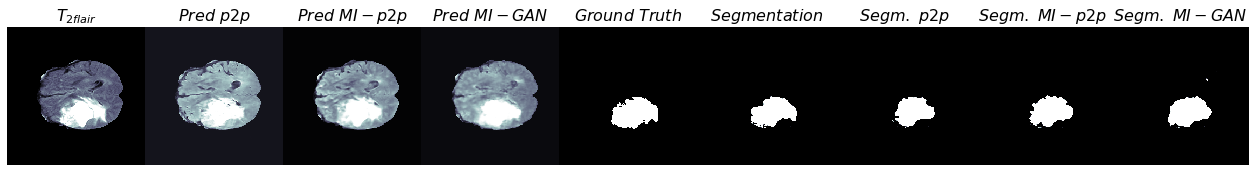

123


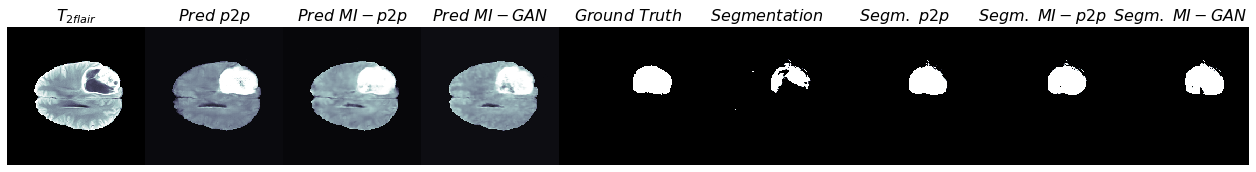

120


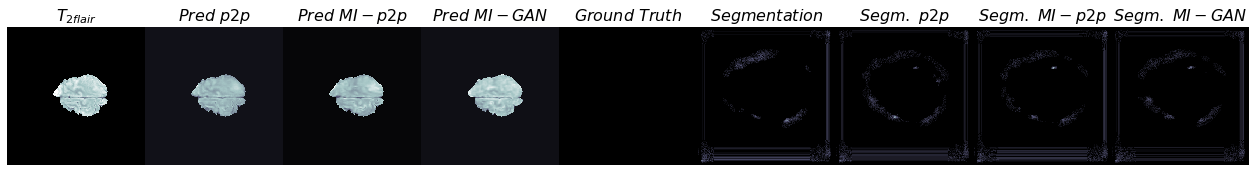

126


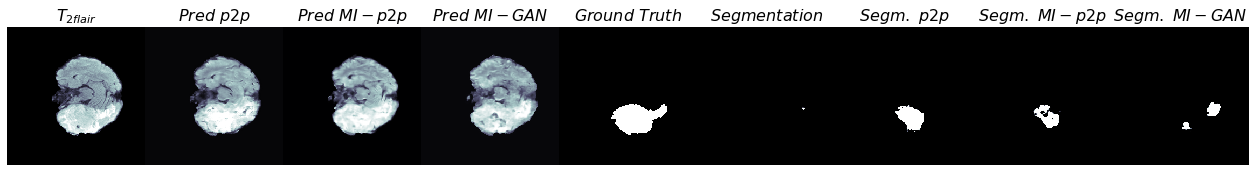

In [0]:
indexes = [6, 20, 26, 39, 42, 54, 72, 74, 76, 81, 96, 114, 123, 120, 126]     # selecting the most interesting samples from the dataset
for i in indexes:
    print(i)
    plot_images(tflair[i], p2p_pred[i], mip2p_pred[i], migan_pred[i], gt[i], segmentation[i], segm_p2p_pred[i], segm_mip2p_pred[i], segm_migan_pred[i])